In [6]:
import os
import copy
import zipfile
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio import mask as msk 
from matplotlib import pyplot as plt  
from osgeo import gdal, ogr
import geopandas as gpd

download_data = False
buffer_dist = 30 # define buffer dist here (CVL proposal 30 meter)
Lakes_url = 'https://hs.pangaea.de/sat/NitzeI-etal_2018/Lakes_T1.zip'
Landcover_url = 'https://hs.pangaea.de/sat/GlobPermafrost_Sentinel/Landcover/ZAM_LCP_LANDC_SEN12_V02_20150815_20180830_T01.tif'
# include ERA5 Data for selected area!
era5_url
print('download_data:', download_data)

if os.path.exists('data') == False:
    os.makedirs('data')

download_data: False


In [2]:
#download data
if download_data == True:
    print('___loading Landcover')
    
    if os.path.exists('data/ds_landcover.tif') == False:
        download_string = 'wget -O -q data/ds_landcover.tif {}'.format(Landcover_url)
        os.system(download_string)
    ds_landcover =  rio.open(Landcover_url)

    print('___loading Trends')
    if os.path.exists('data/Lakes_T1/T1_WS_Lakes.shp') == False:
        print ('downloading and open dataset trend-Lakes')
        download_string = 'wget -O -q data/Lakes_T1.zip {}'.format(Lakes_url) 
        os.system(download_string)
        with zipfile.ZipFile('data/Lakes_T1.zip', 'r') as zip_ref:
            zip_ref.extractall('data')
        print('data downloaded')

    ds_trend = gpd.read_file('data/Lakes_T1/T1_WS_Lakes.shp')          
    print('dataset loaded')
    
else:
    ds_landcover = rio.open('data/ds_landcover.tif')
    print('ds_landcover loaded')
    ds_trend = gpd.read_file('data/Lakes_T1/T1_WS_Lakes.shp')   
    print('ds_trend loaded')

print('all datasets are loaded!')

ds_landcover loaded
ds_trend loaded


In [3]:
#ds_trend[ds_trend.ID == 45136]
Lake_1 = ds_trend[ds_trend.index ==69361]
Lake_1 = Lake_1.to_crs(crs = 32642) #change coordinate system
Lake_ID = list(ds_trend[ds_trend.index ==69361].ID)

Lake_2 = ds_trend[ds_trend.index ==72306]
Lake_2 = Lake_2.to_crs(crs = 32642)

In [4]:
#lakes of interest = nt_ch_pc = - and größer als zb -90 percent
Lakes_OI = copy.deepcopy(ds_trend[ds_trend.nt_ch_pc <= -90]).reset_index(drop=True)
#Lakes_OI

In [331]:
#cut now the landcover with this particular lake
#out_image, out_transform = msk.mask(ds_landcover, Lake_2.geometry, crop=True)
#out_meta = ds_landcover.meta
#out_meta.update({"driver": "GTiff",
#                 "height": out_image.shape[1],
#                 "width": out_image.shape[2],
#                 "transform": out_transform})
#
#if os.path.exists('temp') == False:
#    os.mkdir('temp')
#    
#with rio.open('temp/temp.tif', "w", **out_meta) as dest:
#    dest.write(out_image)
    

0    34
Name: ID, dtype: int64
main classes are: ['Water', 'Disturbed', 'Floodplain']
present_classes: 9
diversity index: 0.7986645376687473


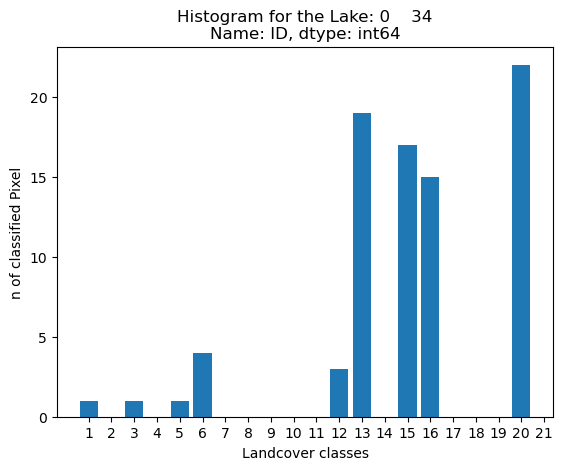

press any key to continue 


0    558
Name: ID, dtype: int64
main classes are: ['Water', 'Floodplain', 'Disturbed']
present_classes: 14
diversity index: 0.8386232890299544


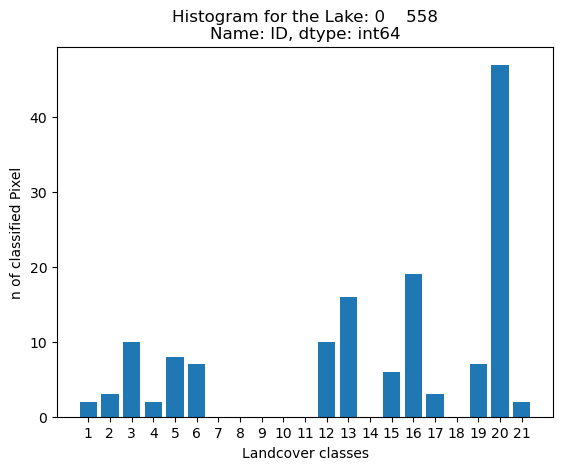

KeyboardInterrupt: Interrupted by user

In [7]:
#cut now the landcover with this particular lake
for i in Lakes_OI.index:
    #Lake_ID = Lakes_OI.ID[i]
    Lake = copy.deepcopy(Lakes_OI[Lakes_OI.index == i]).reset_index(drop = True)
    Lake_ID = Lake.ID

    print(Lake_ID)
    Lake = Lake.to_crs(crs = 32642)
    Lake.geometry = copy.deepcopy(Lake.buffer(buffer_dist,join_style=1))

    out_image, out_transform = msk.mask(ds_landcover, Lake.geometry, crop=True)
    out_meta = ds_landcover.meta
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    if os.path.exists('temp') == False:
        os.mkdir('temp')

    with rio.open('temp/temp.tif', "w", **out_meta) as dest:
        dest.write(out_image)
        
    #analyze the cutted lake
    ds = gdal.Open('temp/temp.tif', gdal.GA_ReadOnly)
    b_ds = ds.GetRasterBand(1) 
    b_ds_data = b_ds.ReadAsArray().astype(np.float32)
    
    #make the nan values
    dimension = np.shape(b_ds_data)
    db_image = copy.deepcopy(b_ds_data)
    for i in range(dimension[0]):
        for j in range(dimension[1]):
            if b_ds_data[i,j] == 255:
                db_image[i,j]=np.nan
   
    #calc the percent
    
    #prepare the data
    classes, count = np.unique(db_image,return_counts=True)
    tot_sum = np.sum(count[0:(len(count)-1)]) #last value from count is count of nan values which is negligible
    real_classes = real_classes = range(1,22)

    labels = ['Sparse vegetation',
              'Sparse vegetation',
              'Shrub tundra',
              'Shrub tundra',
              'Shrub tundra',
              'Shrub tundra',
              'Shrub tundra',
              'Forest',
              'Forest',
              'Forest',
              'Grassland',
              'Floodplain',
              'Disturbed',
              'Floodplain',
              'Floodplain',
              'Floodplain',
              'Barren',
              'Barren',
              'Water',
              'Water',
              'Water']

    #calc main classes
    data = []
    for i in real_classes:
        data.append(i)
    data = pd.DataFrame({'classes':data})
    labels = pd.DataFrame(labels)
    df = data.join(labels)
    dataframe = pd.DataFrame({'classes':classes[0:-1], 'count':count[0:-1]})
    class_data = df.set_index('classes').join(dataframe.set_index('classes'))
    class_data = class_data.reset_index()
    three_main_classes = class_data.sort_values(by=['count'],ascending=False)[0:3]
    print('main classes are:',list(three_main_classes[0]))
    
    #percent
    pixel_summe = np.sum(count[0:-1]) #exclude nan count!
    prozente = (count[0:-1]/pixel_summe)*100
    present_classes = len(classes[0:-1])
    print('present_classes:', present_classes)
    
    #diversity index
    #1 = divers 0 = mono
    n_classes = len(dataframe)
    # Diversity_in_classes_Index
    DIC_I = n_classes / len(real_classes)
    temp = class_data.sort_values(by=['count'],ascending=False)
    temp = list(temp['count'])
    pixel_summe = np.nansum(temp) 

    #verteilung
    verteilung = []
    for i in temp:
        verteilung.append((i / pixel_summe)**2) 
    #https://de.wikipedia.org/wiki/Simpson-Index
    #https://www.researchgate.net/publication/311506613_Diversity_erfassen_Statistische_Diversitatsindizes

    Div_index = 1 - np.nansum(verteilung)
    print('diversity index:', Div_index)

    
    #histogram
    plt.title('Histogram for the Lake: {}'.format(Lake_ID))
    plt.bar(classes[0:(len(count)-1)],count[0:(len(count)-1)])
    plt.xlabel('Landcover classes')
    plt.ylabel('n of classified Pixel')
    plt.xticks(real_classes)

    
    #[ax.text(v, i, '{:.2f}%'.format(100*v)) for i, v in enumerate(s)];
    #plt.bar_label(bar)
    plt.show()
    
    input('press any key to continue')

In [8]:
#analyze the cutted lake
ds = gdal.Open('temp/temp.tif', gdal.GA_ReadOnly)
b_ds = ds.GetRasterBand(1) 
b_ds_data = b_ds.ReadAsArray().astype(np.float32)


In [9]:
#make the nan values
dimension = np.shape(b_ds_data)
db_image = copy.deepcopy(b_ds_data)
for i in range(dimension[0]):
    for j in range(dimension[1]):
        if b_ds_data[i,j] == 255:
            db_image[i,j]=np.nan


In [95]:
#calc the percent
#prepare the data
classes, count = np.unique(db_image,return_counts=True)
tot_sum = np.sum(count[0:(len(count)-1)]) #last value from count is count of nan values which is negligible
real_classes = range(1,22)

labels = ['Sparse vegetation',
          'Sparse vegetation',
          'Shrub tundra',
          'Shrub tundra',
          'Shrub tundra',
          'Shrub tundra',
          'Shrub tundra',
          'Forest',
          'Forest',
          'Forest',
          'Grassland',
          'Floodplain',
          'Disturbed',
          'Floodplain',
          'Floodplain',
          'Floodplain',
          'Barren',
          'Barren',
          'Water',
          'Water',
          'Water']

In [10]:
#calc main classes
data = []
for i in real_classes:
    data.append(i)
data = pd.DataFrame({'classes':data})
labels = pd.DataFrame(labels)
df = data.join(labels)
dataframe = pd.DataFrame({'classes':classes[0:-1], 'count':count[0:-1]})
class_data = df.set_index('classes').join(dataframe.set_index('classes'))
class_data = class_data.reset_index()
three_main_classes = class_data.sort_values(by=['count'],ascending=False)[0:3]
print('main classes are:',list(three_main_classes[0]))

main classes are: ['Water', 'Floodplain', 'Disturbed']


In [11]:
#diversity index
#1 = divers 0 = mono


n_classes = len(dataframe)

# Diversity_in_classes_Index
DIC_I = n_classes / len(real_classes)

temp = class_data.sort_values(by=['count'],ascending=False)
temp = list(temp['count'])

pixel_summe = np.nansum(temp) 

#verteilung
verteilung = []
for i in temp:
    verteilung.append((i / pixel_summe)**2) 

verteilung

#https://de.wikipedia.org/wiki/Simpson-Index
#https://www.researchgate.net/publication/311506613_Diversity_erfassen_Statistische_Diversitatsindizes

Div_index = 1 - np.nansum(verteilung)

Div_index

0.8386232890299544

In [56]:
#percent
pixel_summe = np.sum(count[0:-1]) #exclude nan count!
prozente = (count[0:-1]/pixel_summe)*100
present_classes = len(classes[0:-1])
present_classes

4

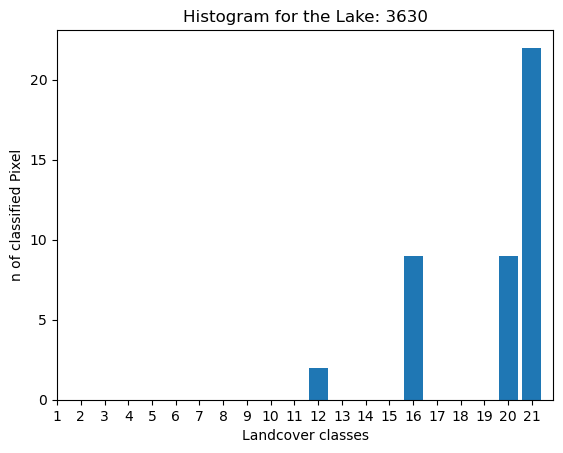

In [57]:
#histogram

plt.title('Histogram for the Lake: {}'.format(list(Lake_ID)[0]))
plt.bar(classes[0:(len(count)-1)],count[0:(len(count)-1)])
plt.xlabel('Landcover classes')
plt.ylabel('n of classified Pixel')
plt.xticks(real_classes)
#make x achse fix mit allen klassen

#[ax.text(v, i, '{:.2f}%'.format(100*v)) for i, v in enumerate(s)];
#plt.bar_label(bar)
plt.show()

In [1]:
bar

NameError: name 'bar' is not defined

In [16]:
data_paths

['data/era5\\yamal_temp_2015_2021.grib',
 'data/era5\\yamal_precip_2015_2021.grib']

In [82]:
# include ERA5 Data for selected area!

write = True

import os
import pygrib
import numpy as np
import pandas as pd
import geopandas as gpd


data = r'data/era5'
cut_data = copy.deepcopy(Lake)
cut_data.geometry = copy.deepcopy(Lake.buffer(buffer_dist+10000,join_style=1))
begin_of_dataset = 2015

outfile = 'temp/temp_era5.pkl'

data_paths = []
for root, dirs, files in os.walk(data):
        for d in files:
            if d.endswith('.grib'):
                data_paths.append(root+'/'+d)
                
last_year = 0
last_month = 0
for i in range(0,len(data_paths)):
    print('reading data')
    print(data_paths[i])
    grbs = pygrib.open(data_paths[i])
    
    date = []
    mean = []
    median = []
    min_ = []
    max_ = []
    year = []
    month = []
    day = []
    
    print('masking .grib file to extend in the defining shapefile')
    print('using dataset from:',begin_of_dataset)
    for grb in grbs.select():
        #input(grb.keys()) 
        # for i in grb.keys():
        #     try:
        #         output = str(grb[i])
        #     except:
        #         output = '_nan_'
        #     print('\n{}\t\t{}'.format(i,output))
        
        data = grb.latLonValues
        ts = str(grb.julianDay).replace('.','_') 
        write = False
        outfile =  'temp/temp_era5_{}.pkl'.format(grb.parameterName)
        if not os.path.isfile(outfile):
            if grb.year >= begin_of_dataset:
                write = True
                if not grb.year == last_year:
                    print('Year:',grb.year)
                last_year = grb.year
                
                if not grb.month == last_month:
                    print('Month:',grb.month)
                last_month = grb.month
            
            
                lat_lon_val = ([],[],[])
                u = 0
                for j in range(0,(len(data))):
                    k = 0
                    if u == 2:
                        u = 0
                        k = 1
                        if 'temperature' in grb.parameterName:
                            lat_lon_val[2].append(data[j]-273.15) #unit K to °C
                            scale = 'Grad Celsius'
                        if 'precipitation' in grb.parameterName: 
                            lat_lon_val[2].append(data[j]*1000)  #unit m to mm  
                            scale = 'Millimeter'
                    if u == 1:
                        u = u + 1
                        lat_lon_val[1].append(data[j])
                    if u == 0 and k == 0:
                        u = u + 1
                        lat_lon_val[0].append(data[j])
                
                lat_lon_val =np.array(lat_lon_val)
                lat_lon_val=lat_lon_val.transpose()
        
                pointDf = pd.DataFrame(lat_lon_val)
                pointDf.rename( columns={2 :'values'}, inplace=True )

                gdf = gpd.GeoDataFrame(pointDf['values'],geometry=gpd.points_from_xy(pointDf[1],pointDf[0]),crs=4326)
                #cut_data = gpd.read_file(cut_shape)
        
                cut_data = copy.deepcopy(cut_data.to_crs(4326))
                gdf = gdf.to_crs(4326) 

                #df1 = gpd.read_file(r'D:\Yamal\temp_precipitation_plot\cropPoints1.shp')
                res_intersection = gdf.overlay(cut_data, how='intersection')
                if 'id' in res_intersection.columns:
                    del res_intersection['id']
                
                #want to check the correct cutted extend:
                #res_intersection.to_file(r'D:\Yamal\data2\Landcover_self_generated\ID45136\test.shp', driver='ESRI Shapefile')
                
                date.append(grb.julianDay)
                mean.append(np.mean(res_intersection['values']))
                median.append(np.median(res_intersection['values']))
                min_.append(np.min(res_intersection['values']))
                max_.append(np.max(res_intersection['values']))
                year.append(grb.year)
                month.append(grb.month)
                day.append(grb.day)
    
    print('generating and writing the masked database', grb.parameterName,' to main folder')
    database = pd.DataFrame({'ID':grb.parameterName,
                             'scale': scale,
                             'date':date,
                             'year':year,
                             'month':month,
                             'day':day,
                             'mean':mean,
                             'median':median,
                             'min':min_,
                             'max':max_})

    outfile = 'temp/temp_era5_{}.pkl'.format(grb.parameterName)
    database.to_pickle(outfile)  # where to save it, usually as a .pkl
        
print('done')

reading data
data/era5/yamal_temp_2015_2021.grib
masking .grib file to extend in the defining shapefile
using dataset from: 2015
Year: 2015
Month: 1
Month: 2
Month: 3
Month: 4
Month: 5
Month: 6
Month: 7
Month: 8
Month: 9
Month: 10
Month: 11
Month: 12
Year: 2016
Month: 1
Month: 2
Month: 3
Month: 4
Month: 5
Month: 6
Month: 7
Month: 8
Month: 9
Month: 10
Month: 11
Month: 12
Year: 2017
Month: 1
Month: 2
Month: 3
Month: 4
Month: 5
Month: 6
Month: 7
Month: 8
Month: 9
Month: 10
Month: 11
Month: 12
Year: 2018
Month: 1
Month: 2
Month: 3
Month: 4
Month: 5
Month: 6
Month: 7
Month: 8
Month: 9
Month: 10
Month: 11
Month: 12
Year: 2019
Month: 1
Month: 2
Month: 3
Month: 4
Month: 5
Month: 6
Month: 7
Month: 8
Month: 9
Month: 10
Month: 11
Month: 12
Year: 2020
Month: 1
Month: 2
Month: 3
Month: 4
Month: 5
Month: 6
Month: 7
Month: 8
Month: 9
Month: 10
Month: 11
Month: 12
Year: 2021
Month: 1
Month: 2
Month: 3
Month: 4
Month: 5
Month: 6
Month: 7
Month: 8
Month: 9
Month: 10
Month: 11
Month: 12
generating and wr

In [84]:
database

,ID,scale,date,year,month,day,mean,median,min,max
0,Total precipitation,Millimeter,2457023.75,2015,1,1,0.000477,0.000477,0.000477,0.000477
1,Total precipitation,Millimeter,2457023.75,2015,1,1,0.000477,0.000477,0.000477,0.000477
2,Total precipitation,Millimeter,2457023.75,2015,1,1,0.000477,0.000477,0.000477,0.000477
3,Total precipitation,Millimeter,2457023.75,2015,1,1,0.000477,0.000477,0.000477,0.000477
4,Total precipitation,Millimeter,2457023.75,2015,1,1,0.000477,0.000477,0.000477,0.000477
...,...,...,...,...,...,...,...,...,...,...
61356,Total precipitation,Millimeter,2459580.25,2021,12,31,0.003099,0.003099,0.002861,0.003338
61357,Total precipitation,Millimeter,2459580.25,2021,12,31,0.003815,0.003815,0.003815,0.003815
61358,Total precipitation,Millimeter,2459580.25,2021,12,31,0.004530,0.004530,0.004292,0.004768
61359,Total precipitation,Millimeter,2459580.25,2021,12,31,0.005007,0.005007,0.004768,0.005245
